In [146]:
using LinearAlgebra
using PyPlot
import TensorCrossInterpolation as TCI
using QuanticsTCI

include("honeycomb.jl")
include("kanemele.jl")
include("latticeplot.jl")
include("berry.jl")
include("chern.jl")

function displaymatrix(A::Matrix)
    show(stdout, "text/plain", A)
end

function maxlinkdim(n::Integer, localdim::Integer=2)
    return 0:n-2, [min(localdim^i, localdim^(n - i)) for i in 1:(n-1)]
end

maxlinkdim (generic function with 2 methods)

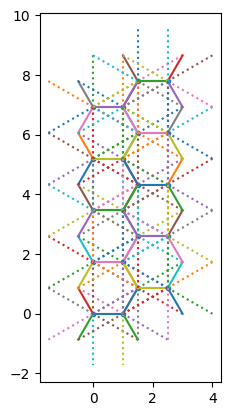

In [121]:
q = 5
B = 4pi / sqrt(3) / q

lattice = honeycomblattice(0, 1, 0, q - 1)

fig, ax = subplots()

sitesplot = collect(zip(realspacecoordinates.(lattice.fromint)...))
ax.plot(sitesplot..., ".")
ax.set_aspect(1)

for s in lattice.fromint
    for n in neighbours(s)
        ax.plot(collect(zip(realspacecoordinates.([s, n])...))...)
    end

    for n in nextneighbours(s)
        ax.plot(collect(zip(realspacecoordinates.([s, n])...))..., ":")
    end
end


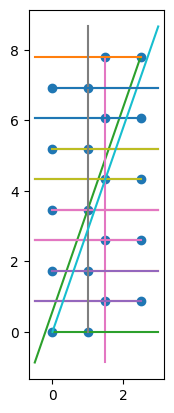

In [122]:
fig, ax = subplots()

sitesplot = collect(zip(realspacecoordinates.(lattice.fromint)...))
ax.plot(sitesplot..., "o")
ax.set_aspect(1)

for s in lattice.fromint
    for n in neighbours(s)
        norig = realspacecoordinates(n)
        nmap = realspacecoordinates(reducesite(n, 1, q))
        ax.plot([norig[1], nmap[1]], [norig[2], nmap[2]])
    end
end

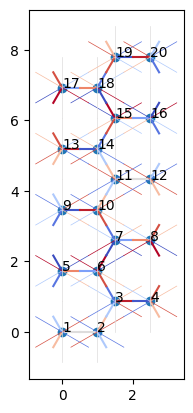

In [123]:
cm = get_cmap("coolwarm")

fig, ax = subplots()

sitesplot = collect(zip(realspacecoordinates.(lattice.fromint)...))
ax.plot(sitesplot..., "o")
ax.set_aspect(1)

for (i, rs) in enumerate(realspacecoordinates.(lattice.fromint))
    ax.annotate(i, xy=rs)
end

phimatrix = zeros(ComplexF64, 4q, 4q)
for (i, s) in enumerate(lattice.fromint)

    for n in neighbours(s)
        phi = peierls(B, s, n)
        rs, rn = realspacecoordinates.([s, n])
        midpoint = (rs + rn) / 2
        ax.plot([rs[1], midpoint[1]], [rs[2], midpoint[2]], color=cm(0.5 * imag(exp(1im * phi)) + 0.5))
    end

    for n in nextneighbours(s)
        phi = peierls(B, s, n)
        phiinv = peierls(B, n, s)

        rs, rn = realspacecoordinates.([s, n])
        midpoint = (rs + rn) / 2
        ax.plot([rs[1], midpoint[1]], [rs[2], midpoint[2]], linewidth=0.5, color=cm(0.5 * imag(exp(1im * phi)) + 0.5))
        phimatrix[i, TCI.pos(lattice, reducesite(n, 1, q))] += exp(1im * phi)
    end
end

In [124]:
Ht = get_Ht(q, [pi / 2, 3], lattice)
#displaymatrix(Ht[:, 1, :, 1])
print("\nHt is hermitian: $([Ht[:, a, :, b] ≈ adjoint(Ht[:, a, :, b]) for a in 1:2, b in 1:2])")


Ht is hermitian: Bool[1 1; 1 1]

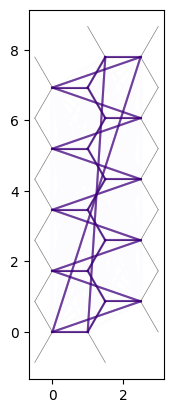

In [125]:
fig, ax = subplots()
displayhamiltonian(ax, abs.(Ht[:, 1, :, 1]), lattice)

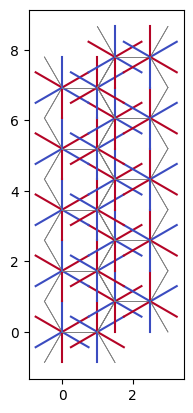

In [126]:
cm = get_cmap("coolwarm")

fig, ax = subplots()
ax.set_aspect(1)

for s in lattice.fromint
    for n in neighbours(s)
        for nn in neighbours(n)
            rs, rn, rnn = realspacecoordinates.([s, n, nn])
            ax.plot([rs[1], rn[1]], [rs[2], rn[2]], color="gray", linewidth=0.5)

            value = sign(antisymmetricproduct(rn - rs, rnn - rn))
            midpoint = (rs + rnn) / 2
            ax.plot([rs[1], midpoint[1]], [rs[2], midpoint[2]], color=cm((1 + value) / 2))
        end
    end
end


Hlambda is hermitian: Bool[1 1; 1 1]


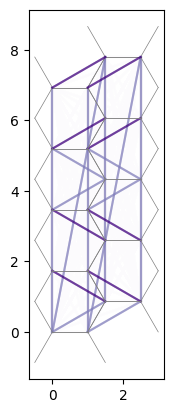

In [127]:
Hlambda = get_Hlambda(q, [0.0, 0.0], lattice)

fig, ax = subplots()
ax.set_aspect(1)
displayhamiltonian(ax, abs.(Hlambda[:, 1, :, 1]), lattice)

println("\nHlambda is hermitian: $([Hlambda[:, a, :, b] ≈ adjoint(Hlambda[:, a, :, b]) for a in 1:2, b in 1:2])")

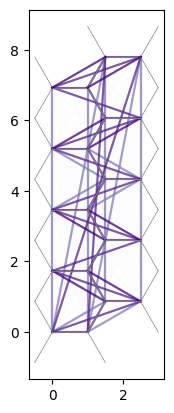

In [128]:
H = get_H(q, 0.6, [0.0, 0.0], lattice)

fig, ax = subplots()
ax.set_aspect(1)
displayhamiltonian(ax, abs.(H[:, 1, :, 1]), lattice)

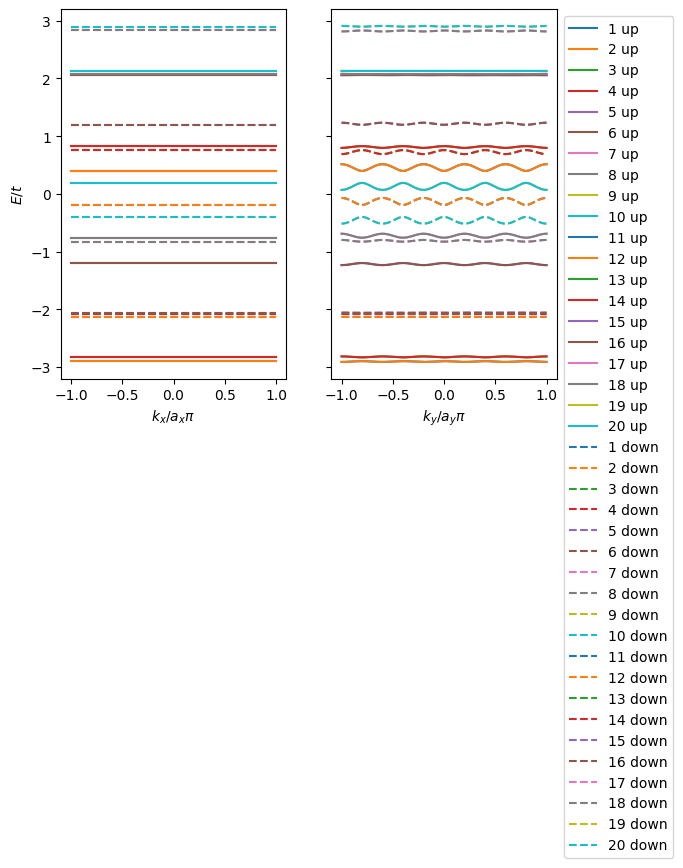

PyObject <matplotlib.legend.Legend object at 0x311bd87c0>

In [129]:
function bands(q, lambdaSO, kx, ky)
    H = get_H(q, lambdaSO, [kx, ky], lattice)
    return eigvals(H[:, 1, :, 1]), eigvals(H[:, 2, :, 2])
end

lambdaSO = 0.2 #/ (3 * sqrt(3))

BZedgex = pi / 1.5
kxvals = range(-BZedgex, BZedgex; length=301)
BZedgey = pi / sqrt(3)
kyvals = range(-BZedgey, BZedgey; length=301)

fig, axs = subplots(ncols=2, sharey=true)

bandsx = bands.(q, lambdaSO, kxvals, 0)

axs[1].plot(kxvals / BZedgex, [b[1] for b in bandsx], "-", label=["$i up" for i in eachindex(bandsx[1][1])])
axs[1].plot(kxvals / BZedgex, [b[2] for b in bandsx], "--", label=["$i down" for i in eachindex(bandsx[1][2])])

bandsy = bands.(q, lambdaSO, 0, kyvals)
axs[2].plot(kyvals / BZedgey, [b[1] for b in bandsy], "-", label=["$i up" for i in eachindex(bandsy[1][1])])
axs[2].plot(kyvals / BZedgey, [b[2] for b in bandsy], "--", label=["$i down" for i in eachindex(bandsy[1][2])])

axs[1].set_xlabel(L"$k_x/a_x\pi$")
axs[2].set_xlabel(L"$k_y/a_y\pi$")
axs[1].set_ylabel(L"$E/t$")
axs[2].legend(loc="upper left", bbox_to_anchor=(1, 1))

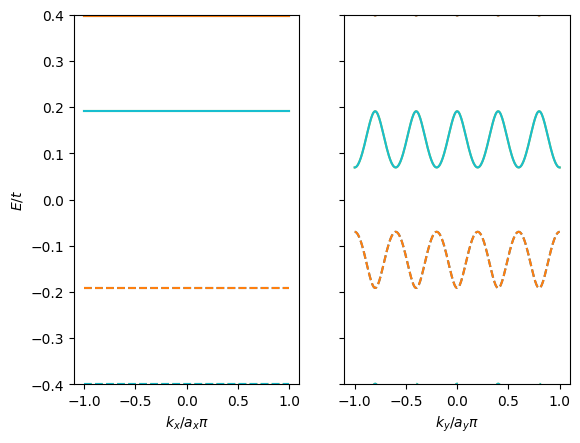

(-0.4, 0.4)

In [130]:
fig, axs = subplots(ncols=2, sharey=true)

bandsx = bands.(q, lambdaSO, kxvals, 0)
axs[1].plot(kxvals / BZedgex, [b[1] for b in bandsx], "-")
axs[1].plot(kxvals / BZedgex, [b[2] for b in bandsx], "--")

bandsy = bands.(q, lambdaSO, 0, kyvals)
axs[2].plot(kyvals / BZedgey, [b[1] for b in bandsy], "-")
axs[2].plot(kyvals / BZedgey, [b[2] for b in bandsy], "--")

axs[1].set_xlabel(L"$k_x/a_x\pi$")
axs[2].set_xlabel(L"$k_y/a_y\pi$")
axs[1].set_ylabel(L"$E/t$")
axs[1].set_ylim(-0.4, 0.4)
axs[2].set_ylim(-0.4, 0.4)

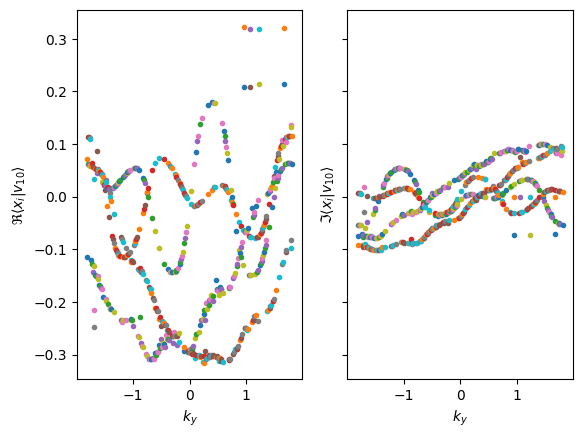

PyObject Text(337.03156565656565, 0.5, '$\\Im\\langle x_i | v_{10} \\rangle$')

In [152]:
function getstate(H, n=1:8q)
    values, vectors = eigen(H[:, 1, :, 1])
    ev = values[n]
    indices = filter(i -> any(values[i] .≈ ev), eachindex(values))
    return vectors[indices]
end

n = 10
A = [getstate(get_H(q, lambdaSO, [0, ky], lattice), [n])[:] for ky in kyvals]

fig, axs = subplots(ncols=2, sharey=true)
for (ky, a) in zip(kyvals, A)
    axs[1].plot([ky], [real.(a)], ".")
    axs[2].plot([ky], [imag.(a) / pi], ".")
end

axs[1].set_xlabel(L"$k_y$")
axs[1].set_ylabel("\$\\Re\\langle x_i | v_{$n} \\rangle\$")
axs[2].set_xlabel(L"$k_y$")
axs[2].set_ylabel("\$\\Im\\langle x_i | v_{$n} \\rangle\$")

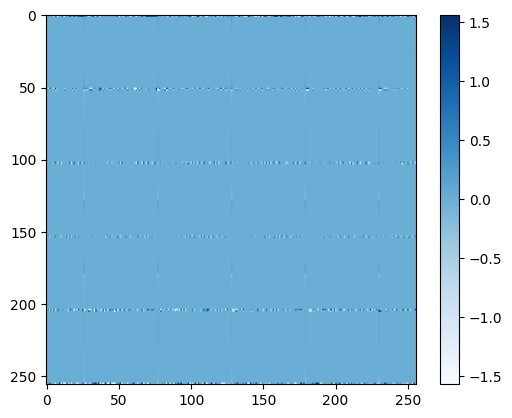

PyObject <matplotlib.colorbar.Colorbar object at 0x35ae7e880>

In [154]:
nquantics = 8
ndiscretization = 2^nquantics

BZedgex = pi / 1.5
kxvals = range(-BZedgex, BZedgex; length=ndiscretization)
BZedgey = pi / sqrt(3)
kyvals = range(-BZedgey, BZedgey; length=ndiscretization)

Hcached = TCI.CachedFunction{Array{Int},Matrix{ComplexF64}}(
    kindex -> get_H(q, lambdaSO, [kxvals[kindex[1]], kyvals[kindex[2]]], lattice)[:, 1, :, 1]
)

H = [Hcached([kxi, kyi]) for kxi in 1:ndiscretization, kyi in 1:ndiscretization]
A = berrycurvature_dets(H, n)
imshow(A, cmap="Blues") |> colorbar

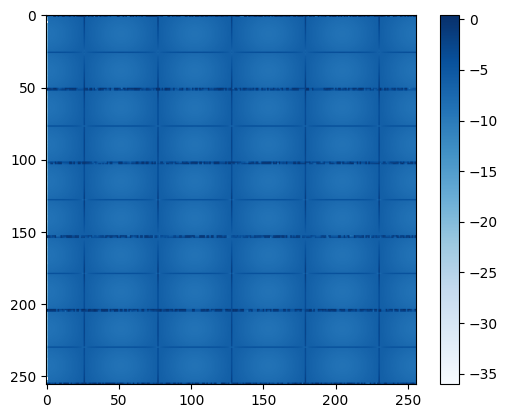

256×256 Matrix{Float64}:
  0.0255971     0.0232623    -0.542539     …  -0.522772     -0.750101
 -0.514302      0.0016441     0.00132692      -1.09907       1.28119
 -1.22125e-14  -0.000388536  -0.000392476     -0.000392476  -0.000388536
 -5.10703e-15  -0.000336068  -0.000339634     -0.000339634  -0.000336068
 -4.88498e-15  -0.000292512  -0.000295766     -0.000295766  -0.000292512
  0.0          -0.000256517  -0.000259511  …  -0.000259511  -0.000256517
 -6.39488e-14  -0.000226952  -0.000229732     -0.000229732  -0.000226952
  1.05915e-13  -0.000202887  -0.000205491     -0.000205491  -0.000202887
  7.99361e-15  -0.000183568  -0.00018603      -0.00018603   -0.000183568
 -2.19824e-14  -0.000168394  -0.000170745     -0.000170745  -0.000168394
  1.39888e-14  -0.000156899  -0.000159165  …  -0.000159165  -0.000156899
  1.55431e-15  -0.000148734  -0.000150939     -0.000150939  -0.000148734
 -5.06262e-14  -0.000143652  -0.00014582      -0.00014582   -0.000143652
  ⋮                              

In [155]:
imshow(log.(abs.(A)), cmap="Blues") |> colorbar
A

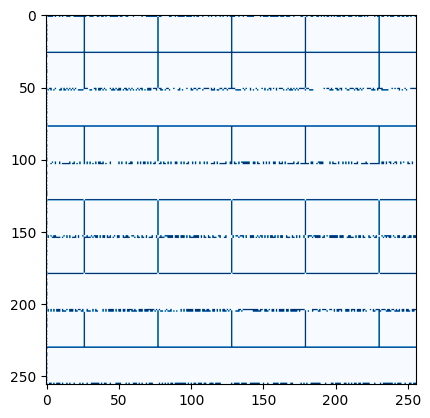

PyObject <matplotlib.image.AxesImage object at 0x35b3106a0>

In [156]:
imshow(sign.(A), cmap="Blues")

In [157]:
band2d = [real(bands(q, lambdaSO, kx, ky)[1][n]) for kx in kxvals, ky in kyvals]

256×256 Matrix{Float64}:
 0.0696336  0.0700104  0.0711369  …  0.0711369  0.0700104  0.0696336
 0.0820106  0.0823741  0.0834606     0.0834606  0.0823741  0.0820106
 0.0945704  0.0949217  0.0959719     0.0959719  0.0949217  0.0945704
 0.107185   0.107526   0.108544      0.108544   0.107526   0.107185
 0.119714   0.120045   0.121036      0.121036   0.120045   0.119714
 0.131997   0.132322   0.133291   …  0.133291   0.132322   0.131997
 0.14385    0.144169   0.145123      0.145123   0.144169   0.14385
 0.15505    0.155366   0.156312      0.156312   0.155366   0.15505
 0.165332   0.165648   0.166592      0.166592   0.165648   0.165332
 0.174383   0.1747     0.175648      0.175648   0.1747     0.174383
 0.181843   0.182163   0.183119   …  0.183119   0.182163   0.181843
 0.187335   0.187658   0.188623      0.188623   0.187658   0.187335
 0.19052    0.190845   0.191817      0.191817   0.190845   0.19052
 ⋮                                ⋱                        ⋮
 0.187335   0.187658   0.18862

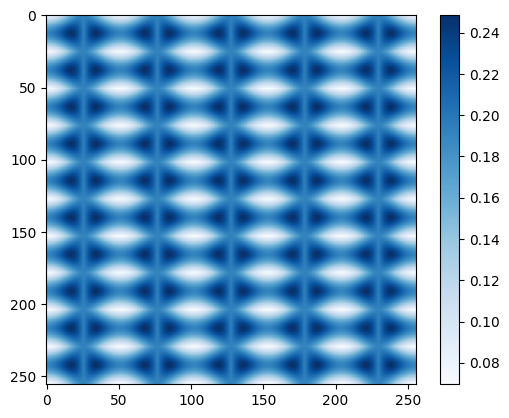

PyObject <matplotlib.colorbar.Colorbar object at 0x35b3aedc0>

In [158]:
imshow(band2d, cmap="Blues") |> colorbar

In [159]:
sum(A) / 2pi

1.999999999999999

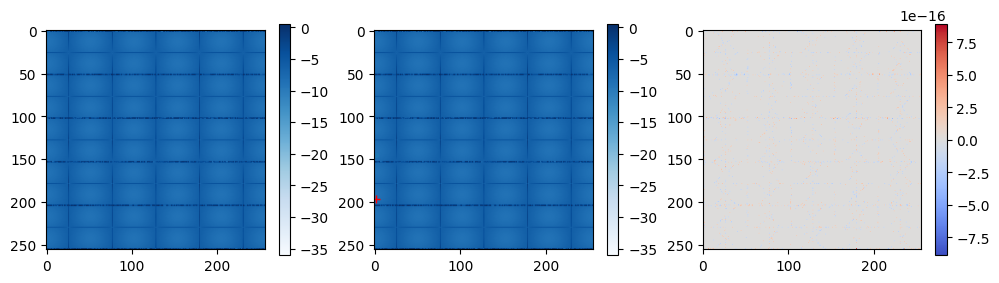

PyObject <matplotlib.colorbar.Colorbar object at 0x35b5a56d0>

In [160]:
f(q) = berrycurvature_quantics(Hcached, n, q, nquantics)

firstpivot = TCI.optfirstpivot(f, fill(4, nquantics))

fig, axs = subplots(ncols=3, figsize=(12, 3))
axs[1].imshow(log.(abs.(A)), cmap="Blues") |> colorbar

quanticsdata = [
    f(index_to_quantics([kxi, kyi], nquantics))
    for kxi in 1:ndiscretization, kyi in 1:ndiscretization
]

axs[2].imshow(log.(abs.(quanticsdata)), cmap="Blues") |> colorbar
axs[2].plot(quantics_to_index(firstpivot, d=2)..., ".")
axs[2].plot(Tuple(argmax(log.(abs.(A))))..., "r+")

axs[3].imshow(quanticsdata .- A, cmap="coolwarm") |> colorbar

In [161]:
tci, ranks, errors = TCI.crossinterpolate(
    f,
    fill(4, nquantics),
    firstpivot,
    tolerance=1e-12,
    maxiter=200,
)

(TensorCI{Float64} with ranks 200, [2, 3, 4, 5, 6, 7, 8, 9, 10, 11  …  191, 192, 193, 194, 195, 196, 197, 198, 199, 200], [1.781899596674222, 2.339106292310423, 2.3700670350509196, 1.8999336944176581, 1.9224082308201869, 2.1234430167216654, 2.2578860838839274, 2.831871815575672, 2.7073469809138593, 1.9682655248653171  …  3.0884719237768106e-6, 2.917302903526767e-6, 2.7570334782778714e-6, 2.677153766391685e-6, 1.9089718320708803e-6, 1.1677297771742975e-6, 1.080339104641323e-6, 8.486497423241205e-7, 4.524962651568613e-7, 4.1007907147290717e-7])

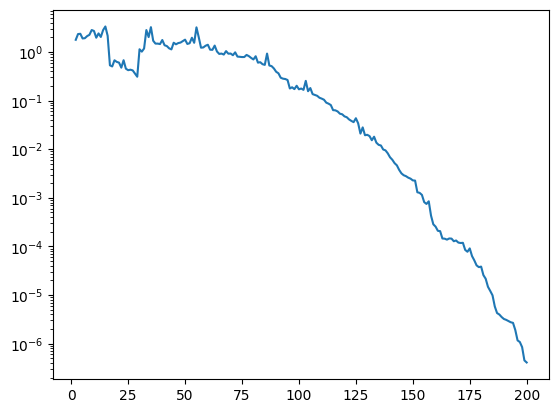

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x35b6c5b20>

In [162]:
semilogy(ranks, errors)

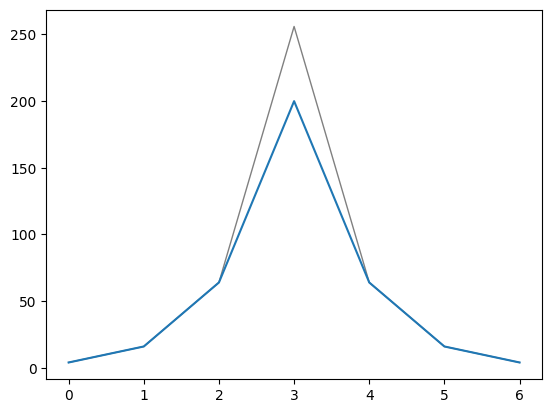

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x35b8fba30>

In [163]:
plot(maxlinkdim(nquantics, 4)..., color="gray", linewidth=1)
plot(TCI.linkdims(tci))

In [164]:
function scalar(a::Matrix)
    if size(a) == (1, 1)
        return first(a)
    else
        throw(ArgumentError("$a is not a scalar."))
    end
end

function evaluate_qtt(qtt, q::Vector{<:Integer})
    return scalar(prod(T[:, i, :] for (T, i) in zip(qtt, q)))
end

qtt = TCI.tensortrain(tci)
qttdata = [
    evaluate_qtt(qtt, index_to_quantics([kxi, kyi], nquantics))
    for kxi in eachindex(kxvals), kyi in eachindex(kyvals)
]

256×256 Matrix{Float64}:
  0.0255971     0.0232623    -0.542539     …  -0.522772     -0.750101
 -0.514302      0.0016441     0.00132692      -1.09907       1.28119
 -5.08652e-15  -0.000388536  -0.000392476     -0.000392476  -0.000388536
  1.15821e-15  -0.000336068  -0.000339634     -0.000339634  -0.000336068
 -3.99025e-14  -0.000292512  -0.000295766     -0.000295766  -0.000292512
 -2.76478e-14  -0.000256517  -0.000259511  …  -0.000259511  -0.000256517
 -4.78807e-14  -0.000226952  -0.000229732     -0.000229732  -0.000226952
  1.24872e-13  -0.000202887  -0.000205491     -0.000205491  -0.000202887
  1.05418e-13  -0.000183568  -0.00018603      -0.00018603   -0.000183568
 -1.26487e-13  -0.000168394  -0.000170745     -0.000170745  -0.000168394
  1.69422e-14  -0.000156899  -0.000159165  …  -0.000159165  -0.000156899
  4.0654e-15   -0.000148734  -0.000150939     -0.000150939  -0.000148734
 -3.58925e-12  -0.000143652  -0.00014582      -0.00014582   -0.000143652
  ⋮                              

vmin = max(min(minimum.([plottransform2.(A), plottransform2.(qttdata)])...), -35) = -35.0
vmax = max(maximum.([plottransform2.(A), plottransform2.(qttdata)])...) = 0.4499915674913049


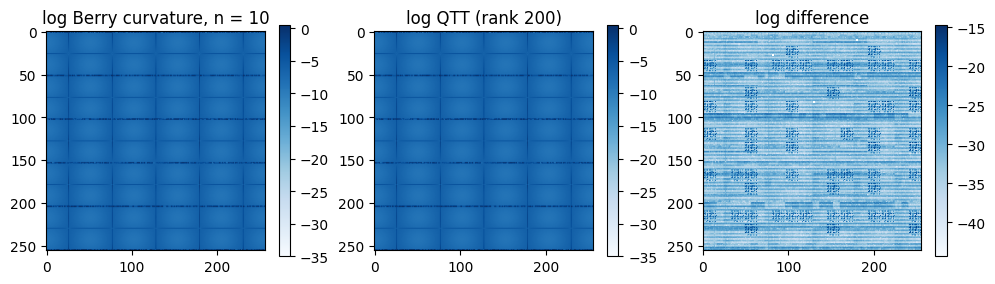

PyObject Text(0.5, 1.0, 'log difference')

In [165]:
plottransform2(x) = log(abs(x))

@show vmin = max(
    min(minimum.([plottransform2.(A), plottransform2.(qttdata)])...),
    -35)
@show vmax = max(maximum.([plottransform2.(A), plottransform2.(qttdata)])...)


fig, axs = subplots(ncols=3, figsize=(12, 3))
axs[1].imshow(plottransform2.(A), cmap="Blues", vmin=vmin, vmax=vmax) |> colorbar
axs[2].imshow(plottransform2.(qttdata), cmap="Blues", vmin=vmin, vmax=vmax) |> colorbar
axs[3].imshow(plottransform2.(qttdata .- A), cmap="Blues") |> colorbar

axs[1].set_title("log Berry curvature, n = $n")
axs[2].set_title("log QTT (rank $(TCI.rank(tci)))")
axs[3].set_title("log difference")

In [167]:
function sumqtt(qtt)
    return prod(sum(T, dims=2)[:, 1, :] for T in qtt)[1]
end

sumqtt(qtt) / 2pi, sum(qttdata) / 2pi, sum(A) / 2pi

(2.000001109224195, 2.000001111739289, 1.999999999999999)